# Fitting Trees and Forests on the Titanic Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
titanic_train = pd.read_csv('https://raw.githubusercontent.com/minsuk-heo/kaggle-titanic/master/input/train.csv')
titanic_test = pd.read_csv('https://raw.githubusercontent.com/minsuk-heo/kaggle-titanic/master/input/test.csv')
titanic_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Preprocess the data

We'll start by dropping categorical variables having many values; these are likely to just lead to overfitting, and will dramatically increase the number of features if they are converted to dummies. We'll also drop rows that have missing values. Finally, we separate out `Survived` as the variable we wish to predict.

In [4]:
from sklearn.preprocessing import LabelEncoder

def preprocess_titanic(dat):
    dat = dat.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    dat = dat.dropna()
    encoded_data = pd.get_dummies(dat)
    if 'Survived' in encoded_data.columns:
        print("Label Found")
        X = encoded_data.drop('Survived', axis=1)
        y = encoded_data['Survived']
    if 'Survived' not in encoded_data.columns:
        print("Label Not Found")
        X = encoded_data
        y = None
    return X, y

In [5]:
X_train, y_train = preprocess_titanic(titanic_train)
X_test, y_test = preprocess_titanic(titanic_test)
X_train.head(5)

Label Found
Label Not Found


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [6]:
# Sex_Male is redundant
X_train = X_train.drop('Sex_male', axis=1)
X_test = X_test.drop('Sex_male', axis=1)

### Growing a Decision tree

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [8]:
params = {'max_leaf_nodes': list(range(2, 100)),
          'max_depth': list(range(2, 7)),
          'min_samples_leaf': list(range(5, 100, 5))}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=1412), 
                              params, 
                              verbose=1, 
                              cv=3)
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 9310 candidates, totalling 27930 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=1412),
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95]},
             verbose=1)

In [9]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=18, min_samples_leaf=5,
                       random_state=1412)

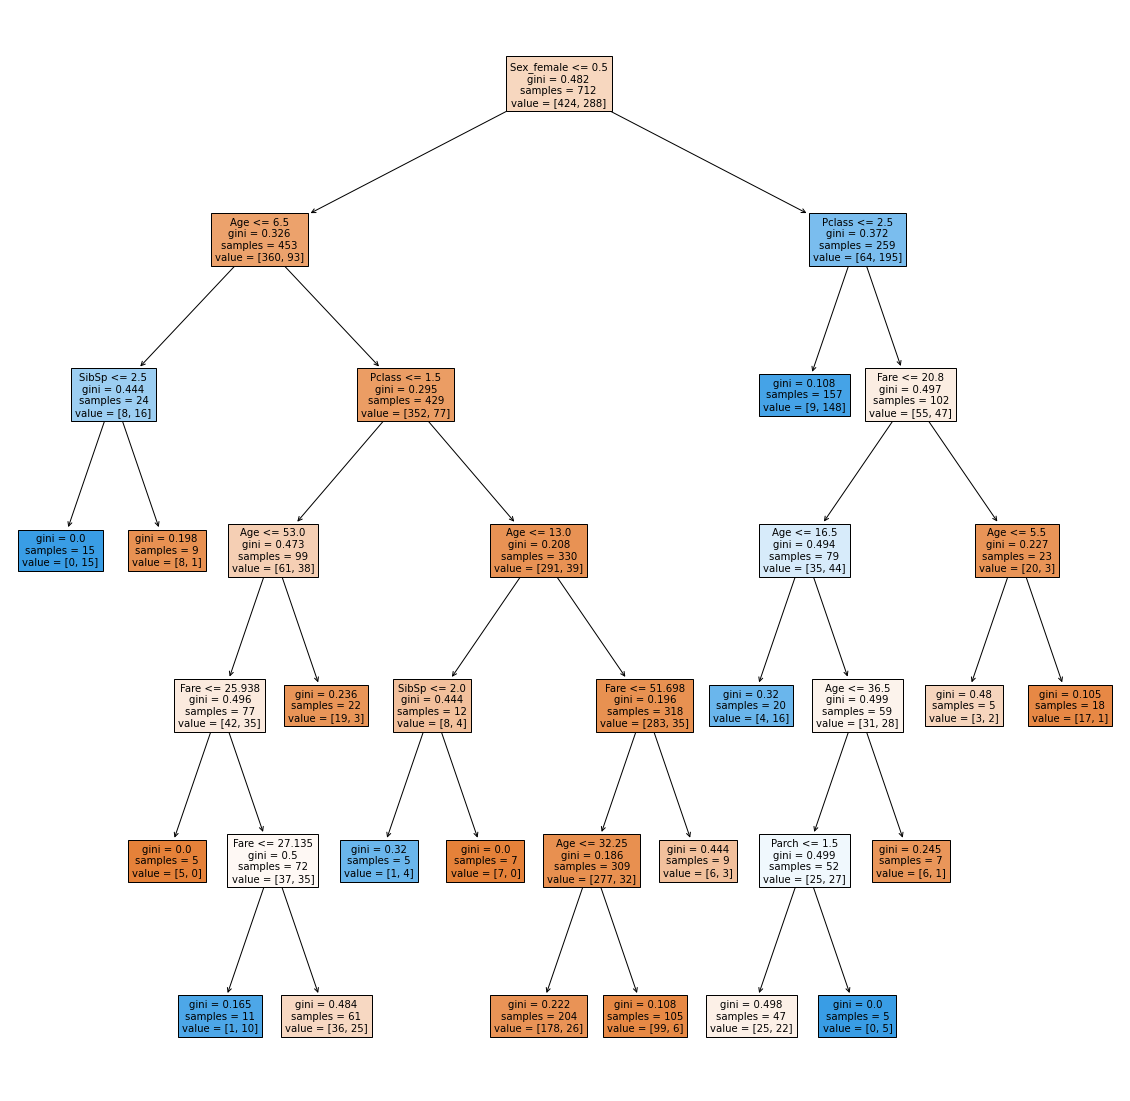

In [10]:
fig = plt.figure(figsize=(20,20))
_ = plot_tree(grid_search_cv.best_estimator_, 
                   filled=True, 
                   feature_names = X_train.columns)

In [11]:
y_test_pred = grid_search_cv.predict(X_test)
print("Number of Survivors in Test Data:", 
      np.sum(y_test_pred == 1))
print("Number of Deaths in Test Data:", 
      np.sum(y_test_pred == 0))

Number of Survivors in Test Data: 108
Number of Deaths in Test Data: 223


### Growing a Random Forest

Nex, we'll build an ensemble of trees using random forests. We'll look at the "out of bag" (OOB) error as we increase the number of trees in the ensemble.

In [12]:
from sklearn import ensemble
from tqdm import tqdm

rf = ensemble.RandomForestClassifier(min_samples_leaf=1, max_features=5, oob_score=True)
oob_error = []
num_trees = np.arange(20, 500, 10)

for m in tqdm(num_trees):
    rf.set_params(n_estimators=m)
    model = rf.fit(X_train, y_train)
    oob_error.append(1-model.oob_score_)

  0%|                                                    | 0/48 [00:00<?, ?it/s]/Users/louisdeschuttere/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
100%|███████████████████████████████████████████| 48/48 [00:15<00:00,  3.08it/s]


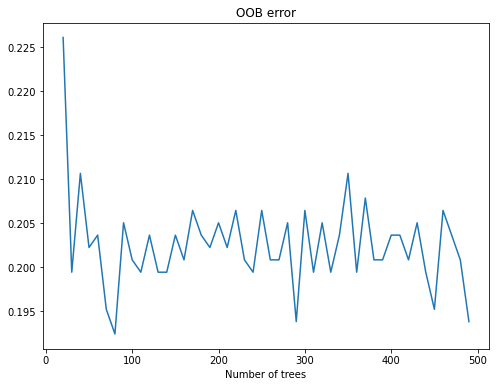

In [13]:
plt.figure(figsize=(8,6))
plt.plot(num_trees, oob_error)
plt.title('OOB error')
plt.xlabel('Number of trees')
plt.show()

Total amount of trees: 80


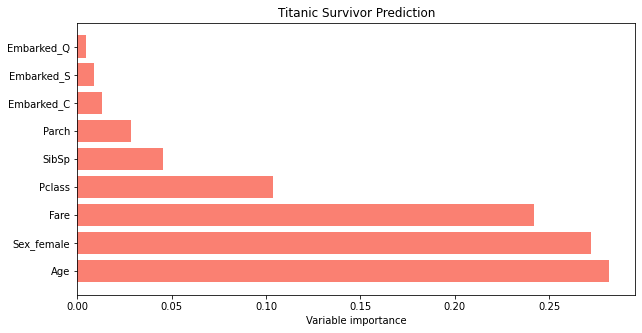

In [14]:
trees = num_trees[np.argmin(oob_error)]
print("Total amount of trees:", trees)

rf.set_params(n_estimators=trees)
model = rf.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(10,5))
inds = np.argsort(model.feature_importances_)
inds = np.flip(inds)
ax.barh(np.arange(9), model.feature_importances_[inds], color='salmon')
ax.set_yticks(np.arange(9))
ax.set_yticklabels(X_train.columns[inds])
ax.set_xlabel('Variable importance')
ax.set_title('Titanic Survivor Prediction')

plt.show()

We find that the most important variables are `Age`, `Fare` and `Sex`. This matches the popular conception of the Titanic disaster (as continued in the popular film starring Leonardo DiCaprio and Kate Winslet), which holds that women, children, and wealthy passengers were given priority for access to the lifeboats.

In [15]:
y_test_pred = model.predict(X_test)
print("Number of Survivors in Test Data:", 
      np.sum(y_test_pred == 1))
print("Number of Deaths in Test Data:", 
      np.sum(y_test_pred == 0))

Number of Survivors in Test Data: 129
Number of Deaths in Test Data: 202
